In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import warnings , os, re
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf

import tensorflow.keras as keras
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from keras.utils import np_utils

from kerastuner.tuners import RandomSearch, BayesianOptimization
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters, Choice

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, rdDistGeom
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
RDLogger.logger().setLevel(RDLogger.CRITICAL)

Create molecule

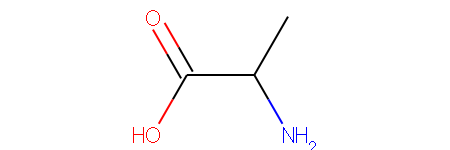

In [2]:
ala = Chem.MolFromSmiles( 'CC(C(=O)O)N' )
ala

In [3]:
Chem.MolToMolBlock(ala)

'\n     RDKit          2D\n\n  6  5  0  0  0  0  0  0  0  0999 V2000\n    0.0000    0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2990    0.7500    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5981   -0.0000    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0\n    2.5981   -1.5000    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    3.8971    0.7500    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0\n    1.2990    2.2500    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0\n  1  2  1  0\n  2  3  1  0\n  3  4  2  0\n  3  5  1  0\n  2  6  1  0\nM  END\n'

In [4]:
Chem.MolToSmiles(ala)

'CC(N)C(=O)O'

In [5]:
Chem.MolToInchi(ala)

'InChI=1S/C3H7NO2/c1-2(4)3(5)6/h2H,4H2,1H3,(H,5,6)'

Geometry optimization

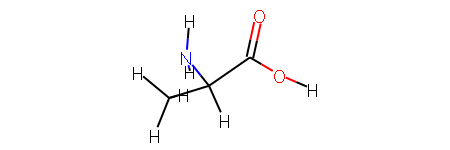

In [6]:
ala = Chem.MolFromSmiles( 'CC(C(=O)O)N' )
alaH = Chem.AddHs(ala)
rdDistGeom.EmbedMolecule(alaH)
alaH

Before= 30.877135098196565
After= 13.281048187832674


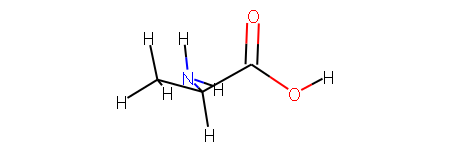

In [7]:
ff = AllChem.UFFGetMoleculeForceField(alaH)
print( "Before=", ff.CalcEnergy() )
AllChem.UFFOptimizeMolecule(alaH)
print( "After=", ff.CalcEnergy() )
alaH

Descriptors, Fingerprints

In [8]:
from rdkit.Chem import Descriptors
from rdkit.Chem.Fingerprints import FingerprintMols

In [9]:
Descriptors.MolWt(alaH), Descriptors.MolLogP(alaH), Descriptors.RingCount(alaH), Descriptors.TPSA(alaH)

(89.09399999999998, -0.5817999999999999, 0, 63.31999999999999)

Database

306-molecules read...


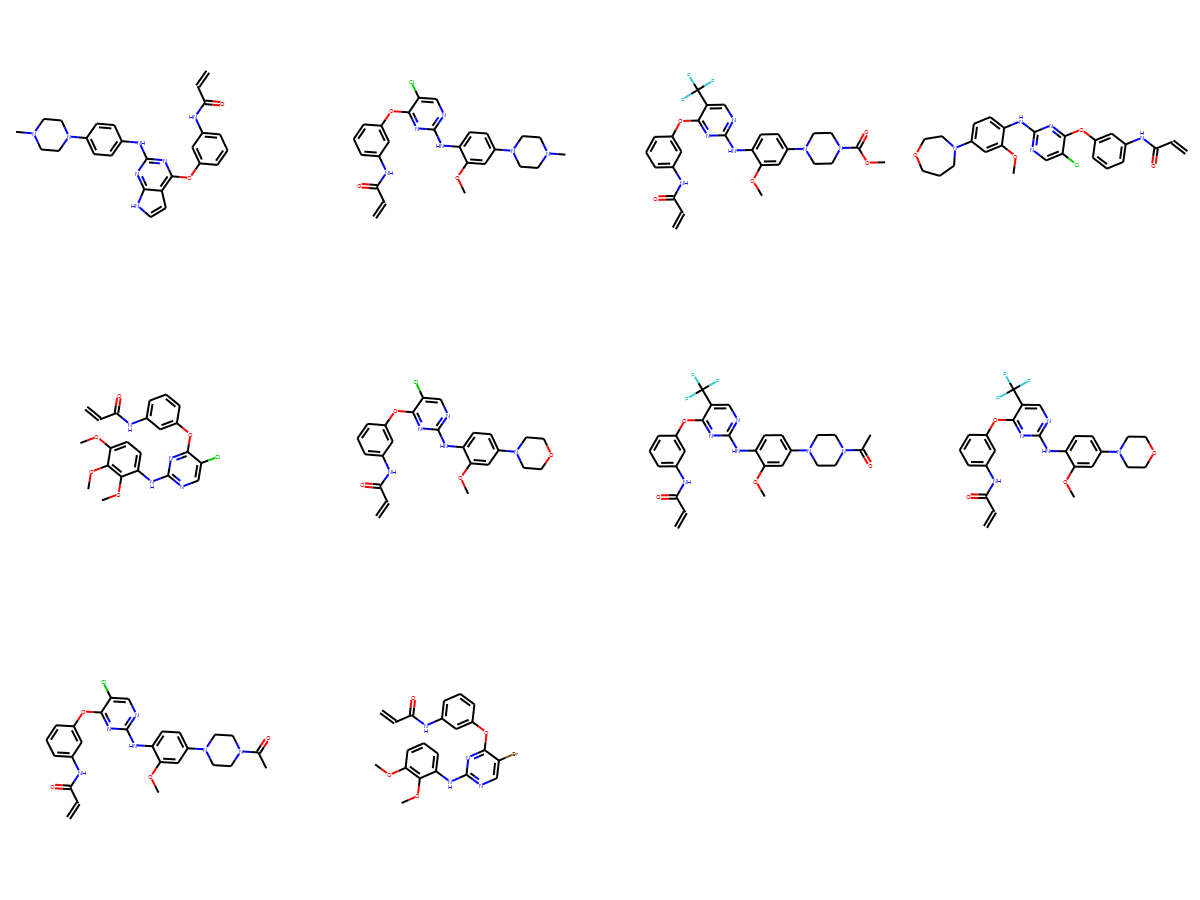

In [10]:
# url = 'https://raw.githubusercontent.com/chchae/VSLecture/master/data/egfr/ChEMBL27_EGFR_aminopyridine.sdf'
# db_egfr = Chem.SDMolSupplier( url )
# mols_egfr = [ x for x in db_egfr if x is not None ]


def mol_from_smiles( row ) :
    smiles = row[ 'smiles' ]
    m = Chem.MolFromSmiles( smiles )
    activity = row[ 'pChembl_Value' ]
    m.SetProp( 'pChembl_Value', str(activity) )
    return m


url_smi = 'https://raw.githubusercontent.com/chchae/VSLecture/master/data/egfr/ChEMBL27_EGFR_aminopyridine.smi'
db_smi = pd.read_table( url_smi, delimiter=' ', names=['smiles', 'pChembl_Value'], header=None, )
mols_egfr = [ mol_from_smiles(row) for _, row in db_smi.iterrows() ]

print( '%d-molecules read...' % len(mols_egfr) )
Draw.MolsToGridImage( mols_egfr[0:10], molsPerRow=4, subImgSize=(300,300) )

Substructure search

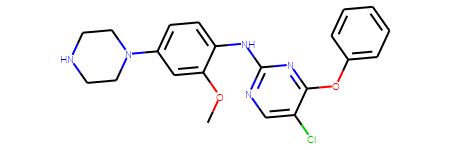

In [11]:
smiles = 'COc1cc(ccc1Nc1ncc(Cl)c(Oc2ccccc2)n1)N1CCNCC1'
query = Chem.MolFromSmiles( smiles )
AllChem.Compute2DCoords(query)
query

Found =  70  from  306


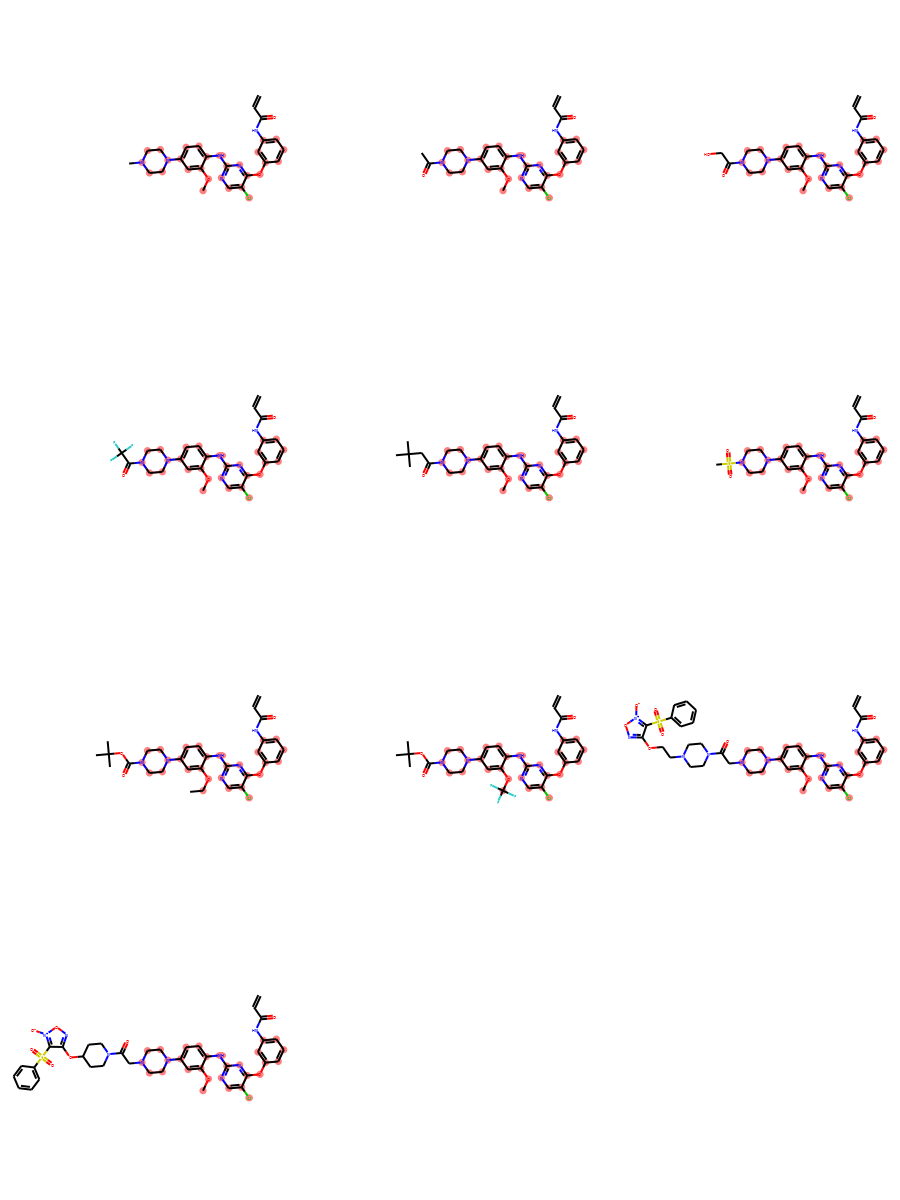

In [12]:
result = [ x for x in mols_egfr if x.HasSubstructMatch(query) ]
print( "Found = ", len( result ), " from ", len( mols_egfr ) )
for m in result:
    AllChem.GenerateDepictionMatching2DStructure( m, query )

Draw.MolsToGridImage( result[:10], molsPerRow=3, subImgSize=(300,300), highlightAtomLists=[ m.GetSubstructMatch(query) for m in result ]  )

Found =  70  from  306


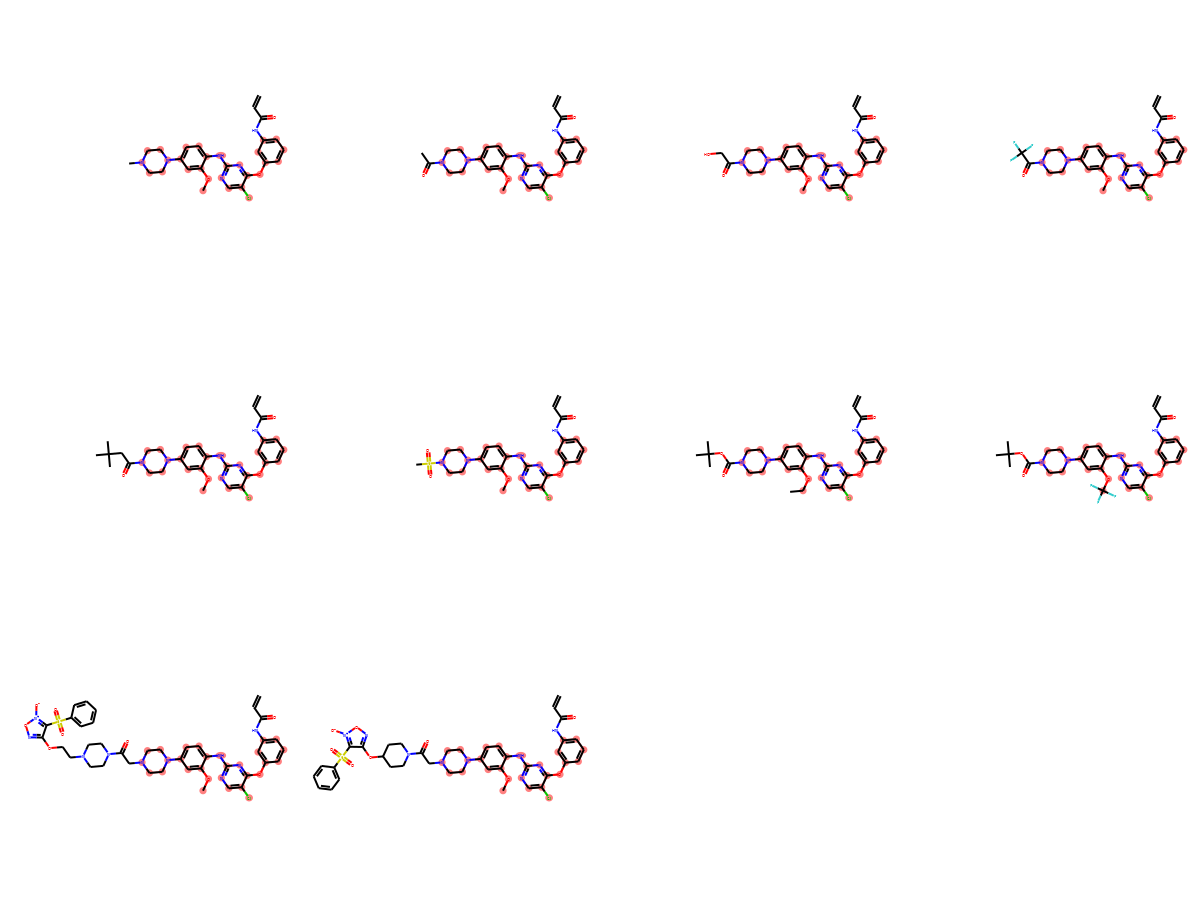

In [13]:
result = [ x for x in mols_egfr if x.HasSubstructMatch(query) ]
print( "Found = ", len( result ), " from ", len( mols_egfr ) )
for m in result:
    AllChem.GenerateDepictionMatching2DStructure( m, query )

Draw.MolsToGridImage( result[:10], molsPerRow=4, subImgSize=(300,300), highlightAtomLists=[ m.GetSubstructMatch(query) for m in result ]  )

MCS

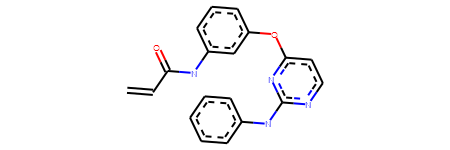

In [14]:
from rdkit.Chem import rdFMCS

mols_sub = mols_egfr[:10]
mcsf = rdFMCS.FindMCS( mols_sub )
mcs = Chem.MolFromSmarts( mcsf.smartsString )
mcs

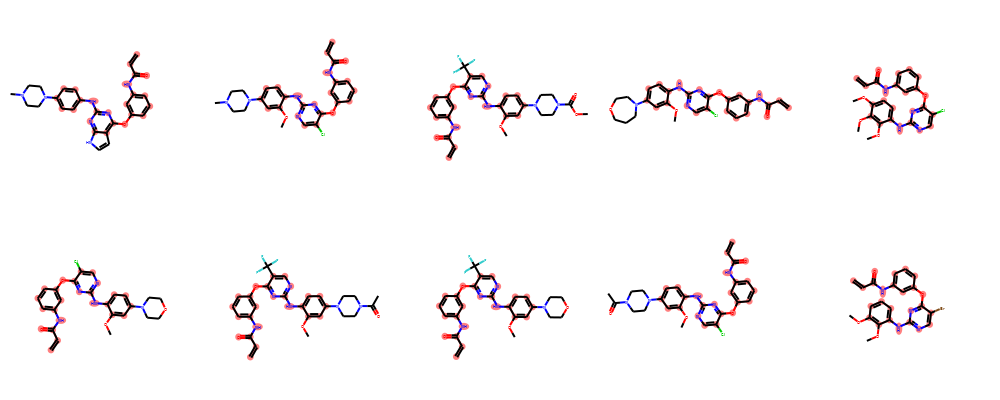

In [15]:
Draw.MolsToGridImage( mols_sub, molsPerRow=5, subImgSize=(200,200), highlightAtomLists=[ m.GetSubstructMatch(mcs) for m in mols_sub ] )

R-Group decomposition

50 0
[{'Core': 'c1cc([*:3])c([*:2])c([*:1])c1Nc1nc([*:5])c([*:4])c([*:6])n1', 'R1': '[H][*:1]', 'R2': '[H][*:2]', 'R3': 'CN1CCN([*:3])CC1', 'R4': 'c(c:[*:4])[nH]:[*:5]', 'R5': 'c(c:[*:4])[nH]:[*:5]', 'R6': 'C=CC(=O)Nc1cccc(O[*:6])c1'}, {'Core': 'c1cc([*:3])c([*:2])c([*:1])c1Nc1nc([*:5])c([*:4])c([*:6])n1', 'R1': 'CO[*:1]', 'R2': '[H][*:2]', 'R3': 'CN1CCN([*:3])CC1', 'R4': 'Cl[*:4]', 'R5': '[H][*:5]', 'R6': 'C=CC(=O)Nc1cccc(O[*:6])c1'}, {'Core': 'c1cc([*:3])c([*:2])c([*:1])c1Nc1nc([*:5])c([*:4])c([*:6])n1', 'R1': 'CO[*:1]', 'R2': '[H][*:2]', 'R3': 'COC(=O)N1CCN([*:3])CC1', 'R4': 'FC(F)(F)[*:4]', 'R5': '[H][*:5]', 'R6': 'C=CC(=O)Nc1cccc(O[*:6])c1'}]


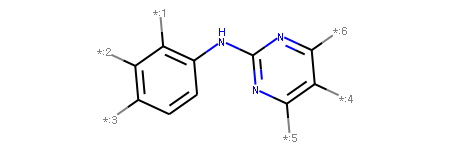

In [16]:
from rdkit.Chem import rdRGroupDecomposition as rdRGD

mcsf = rdFMCS.FindMCS( mols_egfr )
mcs = Chem.MolFromSmarts( mcsf.smartsString )

matched,unmatched = rdRGD.RGroupDecompose([mcs],mols_egfr[:50],asSmiles=True)
print( len(matched), len(unmatched) )
print( matched[:3] )
Chem.MolFromSmiles( matched[0]['Core'])

Fingerprints

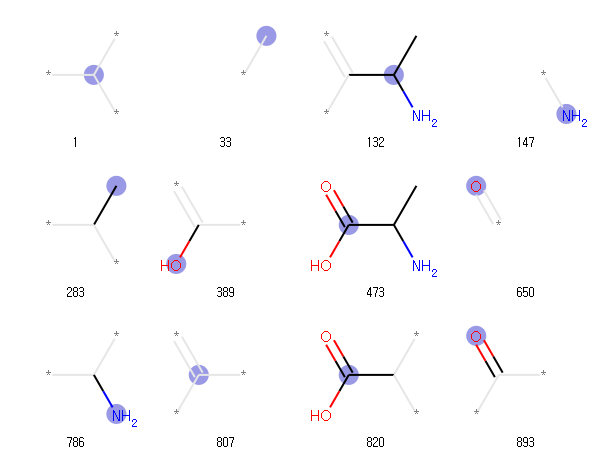

In [17]:
from rdkit.Chem.Fingerprints import FingerprintMols

ala = Chem.MolFromSmiles( 'CC(C(=O)O)N' )
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect( ala, 2, nBits=1024, bitInfo=bi )
#fp_arr = np.zeros( (1, ) )
#DataStructs.ConvertToNumpyArray( fp, fp_arr )
#np.nonzero( fp_arr )
#list( fp.GetOnBits() )

mfps = [ ( ala, x, bi ) for x in fp.GetOnBits() ]
Draw.DrawMorganBits( mfps, molsPerRow=4, subImgSize=(150,150), legends=[ str(x) for x in fp.GetOnBits() ] )

{191: ((3, 1),), 378: ((6, 0), (10, 0)), 389: ((0, 2),), 448: ((7, 2), (9, 2)), 491: ((4, 1),), 703: ((2, 2), (11, 2)), 1088: ((1, 1), (8, 1), (0, 1), (12, 1)), 1152: ((4, 0),), 1199: ((1, 2), (12, 2)), 1380: ((3, 0), (5, 0)), 1452: ((6, 1), (10, 1)), 1524: ((3, 2),), 1582: ((5, 1),), 1586: ((4, 2),), 1619: ((5, 2),), 1750: ((2, 1), (11, 1)), 1819: ((6, 2), (10, 2)), 1866: ((7, 1), (9, 1), (8, 2)), 1873: ((0, 0), (1, 0), (2, 0), (7, 0), (8, 0), (9, 0), (11, 0), (12, 0))}


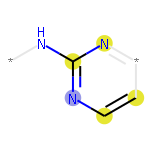

In [18]:
m = Chem.MolFromSmiles( Chem.MolToSmiles(mcs) )
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(m, radius=2, bitInfo=bi)
print( bi )
Draw.DrawMorganBit(m, 1819, bi)

Fingerprint similarity map

In [19]:
import numpy as np

fps = [ FingerprintMols.FingerprintMol(m) for m in mols_egfr ]
fp_ref = fps[1]

val = []
for i in range(len(fps)):
    val.append( DataStructs.FingerprintSimilarity( fp_ref, fps[i] ) )
print( np.array_str( np.array(val), precision=2 ) )

[0.65 1.   0.75 0.88 0.8  0.93 0.77 0.73 0.96 0.71 0.84 0.95 0.72 0.85
 0.92 0.69 0.68 0.91 0.72 0.61 0.67 0.73 0.88 0.88 0.76 0.89 0.87 0.76
 0.63 0.77 0.61 0.75 0.64 0.63 0.66 0.63 0.64 0.71 0.71 0.68 0.62 0.79
 0.73 0.85 0.63 0.63 0.7  0.6  0.77 0.63 0.76 0.63 0.9  0.83 0.57 0.76
 0.81 0.81 0.63 0.6  0.75 0.76 0.92 0.94 0.74 0.84 0.88 0.87 0.73 0.92
 0.93 0.86 0.9  0.85 0.61 0.89 0.95 0.96 0.89 0.83 0.8  0.61 0.92 0.95
 0.61 0.93 0.95 0.58 0.91 0.98 0.97 0.87 0.9  0.83 0.92 0.95 0.87 0.85
 0.91 0.85 0.88 0.87 0.91 0.92 0.81 0.85 0.88 0.87 0.88 0.91 0.5  0.49
 0.49 0.52 0.5  0.47 0.48 0.44 0.53 0.49 0.5  0.51 0.46 0.49 0.5  0.5
 0.49 0.51 0.51 0.47 0.52 0.52 0.49 0.51 0.49 0.51 0.5  0.5  0.43 0.51
 0.44 0.51 0.51 0.5  0.51 0.49 0.5  0.5  0.43 0.56 0.51 0.48 0.52 0.51
 0.44 0.5  0.53 0.52 0.52 0.53 0.52 0.51 0.48 0.51 0.51 0.51 0.51 0.51
 0.48 0.53 0.46 0.53 0.51 0.49 0.5  0.48 0.5  0.47 0.54 0.48 0.55 0.56
 0.6  0.55 0.51 0.58 0.53 0.56 0.57 0.53 0.55 0.48 0.5  0.51 0.49 0.42
 0.46 0

Fingerprint similarity search

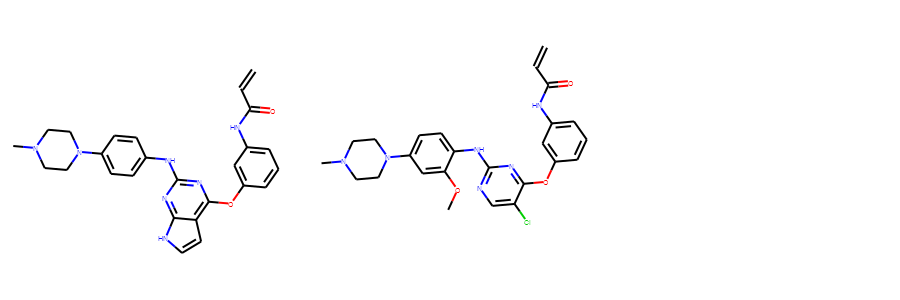

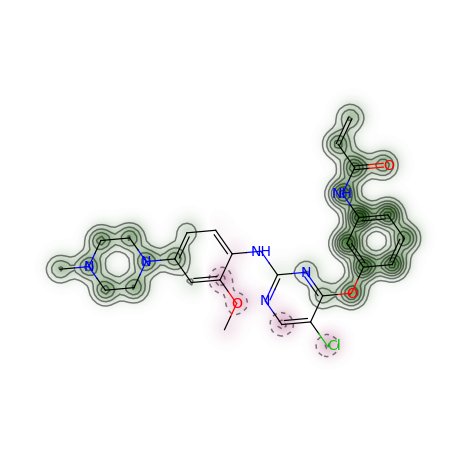

In [20]:
from rdkit.Chem.Draw import SimilarityMaps

ref = mols_sub[0]
mol = mols_sub[1]
fig, maxweight = SimilarityMaps.GetSimilarityMapForFingerprint( ref, mol, SimilarityMaps.GetMorganFingerprint )

Draw.MolsToGridImage( [ref, mol], molsPerRow=3, subImgSize=(300,300) )

In [21]:
fps = [ FingerprintMols.FingerprintMol(m) for m in mols_egfr ]
fp_ref = fps[1]
for i in range(len(fps)):
    print( "%5.2f" % ( DataStructs.FingerprintSimilarity( fp_ref, fps[i] ) ) ) 

 0.65
 1.00
 0.75
 0.88
 0.80
 0.93
 0.77
 0.73
 0.96
 0.71
 0.84
 0.95
 0.72
 0.85
 0.92
 0.69
 0.68
 0.91
 0.72
 0.61
 0.67
 0.73
 0.88
 0.88
 0.76
 0.89
 0.87
 0.76
 0.63
 0.77
 0.61
 0.75
 0.64
 0.63
 0.66
 0.63
 0.64
 0.71
 0.71
 0.68
 0.62
 0.79
 0.73
 0.85
 0.63
 0.63
 0.70
 0.60
 0.77
 0.63
 0.76
 0.63
 0.90
 0.83
 0.57
 0.76
 0.81
 0.81
 0.63
 0.60
 0.75
 0.76
 0.92
 0.94
 0.74
 0.84
 0.88
 0.87
 0.73
 0.92
 0.93
 0.86
 0.90
 0.85
 0.61
 0.89
 0.95
 0.96
 0.89
 0.83
 0.80
 0.61
 0.92
 0.95
 0.61
 0.93
 0.95
 0.58
 0.91
 0.98
 0.97
 0.87
 0.90
 0.83
 0.92
 0.95
 0.87
 0.85
 0.91
 0.85
 0.88
 0.87
 0.91
 0.92
 0.81
 0.85
 0.88
 0.87
 0.88
 0.91
 0.50
 0.49
 0.49
 0.52
 0.50
 0.47
 0.48
 0.44
 0.53
 0.49
 0.50
 0.51
 0.46
 0.49
 0.50
 0.50
 0.49
 0.51
 0.51
 0.47
 0.52
 0.52
 0.49
 0.51
 0.49
 0.51
 0.50
 0.50
 0.43
 0.51
 0.44
 0.51
 0.51
 0.50
 0.51
 0.49
 0.50
 0.50
 0.43
 0.56
 0.51
 0.48
 0.52
 0.51
 0.44
 0.50
 0.53
 0.52
 0.52
 0.53
 0.52
 0.51
 0.48
 0.51
 0.51
 0.51
 0.5

Fingerprint descriptors map

Charges =  [-0.09358991854301577, -0.003956975576191903, 0.24726456668062793, -0.2696480622101046, -0.3223931149276884, 0.04467408980828689, -0.038251682852486216, -0.05649333244031857, -0.01907771727455852, 0.13110971938310126, 0.004446080210662932, -0.4380416880747996, 0.23311161342544373, 0.08147895710961545, 0.1463553925152271, -0.029609010346172172, 0.0033924515283658254, -0.3458645436988424, -0.17606141665813105, 0.23205251307006627, -0.19443948118529558, -0.32402056589798, 0.04102571212272887, -0.036468671449766385, -0.0366908199292375, 0.03681005589562408, -0.0366908199292375, -0.036468671449766385, -0.3689647154567249, 0.030576547955533273, 0.01554920108912078, -0.3028559431986506, -0.013239811541794776, 0.01554920108912078, 0.030576547955533273]
(LogP, MR) =  [(0.1551, 3.513), (0.1551, 3.513), (-0.2783, 5.007), (-0.1526, 0.0), (-0.5188, 3.0), (0.4619, 4.067), (0.1581, 3.35), (0.1581, 3.35), (0.1581, 3.35), (0.5437, 3.853), (0.1581, 3.35), (-0.4195, 1.182), (0.5437, 3.853), (0

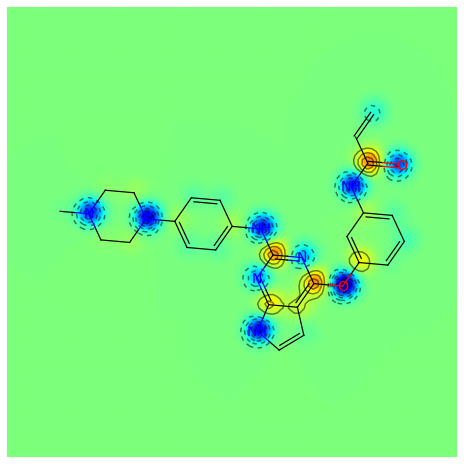

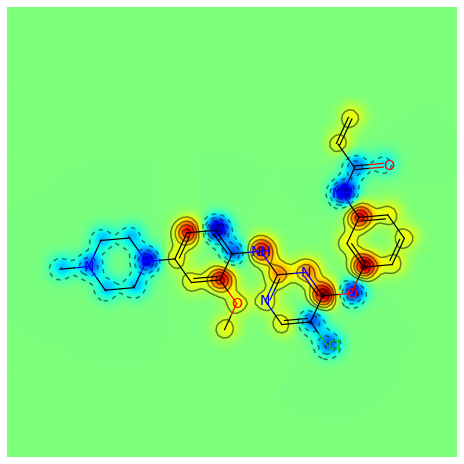

In [22]:
from rdkit.Chem import rdMolDescriptors

m = mols_sub[0]
AllChem.ComputeGasteigerCharges(m)
charges = [ m.GetAtomWithIdx(i).GetDoubleProp('_GasteigerCharge') for i in range(m.GetNumAtoms()) ]
logp = rdMolDescriptors._CalcCrippenContribs(m)
print( "Charges = ", charges )
print( "(LogP, MR) = ", logp )

_ = SimilarityMaps.GetSimilarityMapFromWeights(m, charges, colorMap='jet', contourLines=10)
_ = SimilarityMaps.GetSimilarityMapFromWeights(mol,[x for x,y in logp], colorMap='jet', contourLines=10)

Reactions

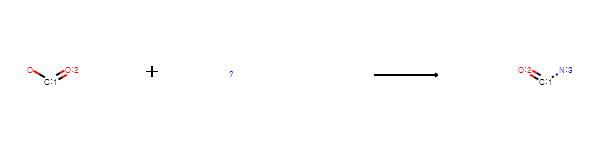

In [23]:
rxn = AllChem.ReactionFromSmarts('[C:1](=[O:2])-[OD1].[N!H0:3]>>[C:1](=[O:2])[N:3]')
rxn

2


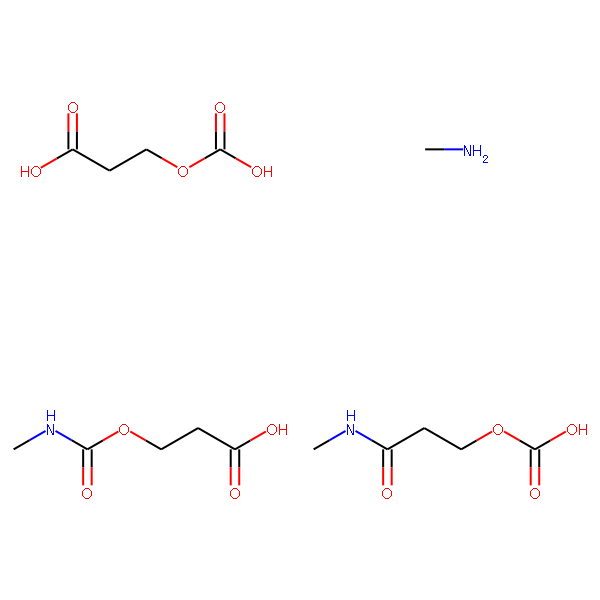

In [24]:
rx1 = Chem.MolFromSmiles('C(COC(=O)O)C(=O)O')
rx2 = Chem.MolFromSmiles('NC')
ps = rxn.RunReactants((rx1,rx2) )
print( len(ps) )
Draw.MolsToGridImage( [ rx1, rx2, ps[0][0], ps[1][0] ], molsPerRow=2, subImgSize=(300,300) )

RECAP

dict_keys(['*C(=O)CC', '*OCCOc1ccccc1', '*c1ccccc1', '*CCOC(=O)CC', '*CCOc1ccccc1'])


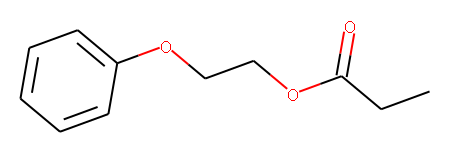

In [25]:
from rdkit.Chem import Recap
m = Chem.MolFromSmiles('c1ccccc1OCCOC(=O)CC')
hierarch = Recap.RecapDecompose(m)
print( hierarch.children.keys() )
hierarch.mol

In [26]:
ks=hierarch.children.keys()
ks

dict_keys(['*C(=O)CC', '*OCCOc1ccccc1', '*c1ccccc1', '*CCOC(=O)CC', '*CCOc1ccccc1'])